In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from scipy.io import loadmat 

In [0]:
!ls

sample_data  test_32x32.mat  train_32x32.mat


In [0]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [0]:
# load data
train_data_set = loadmat('./train_32x32.mat')
test_data_set = loadmat('./test_32x32.mat')

In [0]:
image_size = 32
num_labels = 10
num_channels = 3

X_train = train_data_set['X']
y_train = train_data_set['y']
X_test = test_data_set['X']
y_test = test_data_set['y']

In [0]:
# Приводим к нужной размерности
# X_train1 = X_train.reshape(X_train.shape[3], -1)
X_train = np.transpose(X_train, (3, 0, 1, 2))
X_test = np.transpose(X_test, (3, 0, 1, 2))

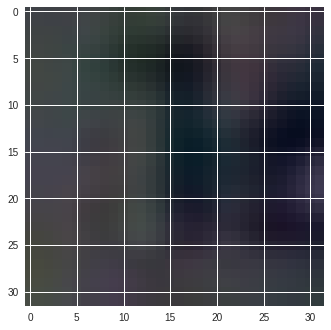

label 1


In [0]:
# check image
plt.imshow(X_train[30000])
plt.show()
print("label {}".format(y_train[30000].squeeze()))

In [0]:
# перемешиваем примеры
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
X_train, y_train = randomize(X_train, y_train)
X_test, y_test = randomize(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(73257, 32, 32, 3) (73257, 1)
(26032, 32, 32, 3) (26032, 1)


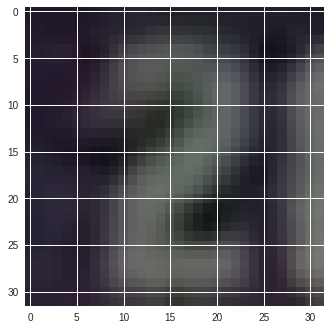

label 2


In [0]:
# check image
plt.imshow(X_train[20000])
plt.show()
print("label {}".format(y_train[20000].squeeze()))

In [0]:
# normalize

X_train = (X_train.astype('float32') / 255)
X_test = (X_test.astype('float32') / 255)

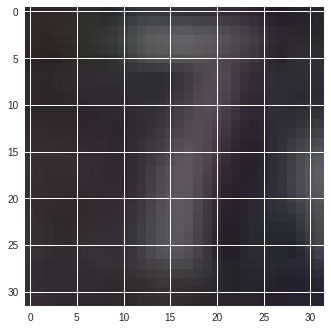

label 7


In [0]:
# check image
plt.imshow(X_train[500])
plt.show()
print("label {}".format(y_train[500].squeeze()))

In [0]:
# one_hot coding labels

y_train[np.where(y_train == 10)] = 0
y_test[np.where(y_test == 10)] = 0
max(y_test)
# y_test[1:100]

y_train = np_utils.to_categorical(y_train, num_labels)
y_test = np_utils.to_categorical(y_test, num_labels)

print(y_train.shape)
print(y_test.shape)

(73257, 10)
(26032, 10)


In [0]:
np.where(y_train == 10)

(array([], dtype=int64), array([], dtype=int64))

In [0]:
# create valid_data_set
valid_dataset = X_train[65000:].astype('float32')
train_dataset = X_train[:65000].astype('float32')
test_dataset = X_test.astype('float32')

train_labels = y_train[:65000]
valid_labels = y_train[65000:]
test_labels =  y_test

print(valid_dataset.shape, train_dataset.shape, test_dataset.shape)
print(valid_labels.shape, train_labels.shape, test_labels.shape)

(8257, 32, 32, 3) (65000, 32, 32, 3) (26032, 32, 32, 3)
(8257, 10) (65000, 10) (26032, 10)


In [0]:
# grayscale
def rgb2gray(dataset):
    nex_matrix = np.zeros([dataset.shape[0], dataset.shape[1], dataset.shape[2]])
    for i in range(dataset.shape[0]):
        r, g, b = dataset[i,:,:,0], dataset[i,:,:,1], dataset[i, :,:,2]
        nex_matrix[i] = 0.2989 * r + 0.5870 * g + 0.1140 * b
    nex_matrix = nex_matrix[:, :, :, np.newaxis].astype('float32')
    return nex_matrix

train_dataset = rgb2gray(train_dataset)
valid_dataset = rgb2gray(valid_dataset)
test_dataset = rgb2gray(test_dataset)
print(valid_dataset.shape, train_dataset.shape, test_dataset.shape)
num_channels = 1

(8257, 32, 32, 1) (65000, 32, 32, 1) (26032, 32, 32, 1)


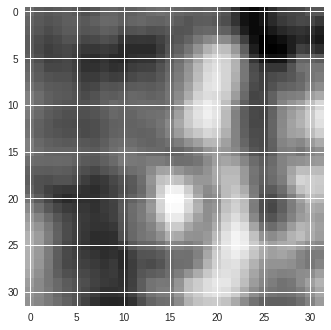

label [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [0]:
# check image
import matplotlib.cm as cm

plt.imshow(train_dataset[31000].reshape(train_dataset.shape[1], train_dataset.shape[2]))
plt.show()

print("label {}".format(train_labels[31000].squeeze()))

In [0]:
# in line
train_dataset = train_dataset.reshape(train_dataset.shape[0], -1)
valid_dataset = valid_dataset.reshape(valid_dataset.shape[0], -1)
test_dataset = test_dataset.reshape(test_dataset.shape[0], -1)
print(valid_dataset.shape, train_dataset.shape, test_dataset.shape)

(8257, 1024) (65000, 1024) (26032, 1024)


In [0]:
# many_layers

batch_size = 512
hidden_units_1 = 1024
hidden_units_2 = 512
hidden_units_3 = 128
# hidden_units_4 = 256
# hidden_units_5 = 256
# hidden_units_6 = 128
lambd = 0.001

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_units_1]))
    biases1 = tf.Variable(tf.zeros([hidden_units_1]))
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_units_1, hidden_units_2]))
    biases2 = tf.Variable(tf.zeros([hidden_units_2]))
    
    weights3 = tf.Variable(
    tf.truncated_normal([hidden_units_2, hidden_units_3]))
    biases3 = tf.Variable(tf.zeros([hidden_units_3]))
    
    weights4 = tf.Variable(tf.truncated_normal([hidden_units_3, num_labels]))
    biases4 = tf.Variable(tf.zeros([num_labels]))
    
#     weights5 = tf.Variable(
#     tf.truncated_normal([hidden_units_4, hidden_units_5]))
#     biases5 = tf.Variable(tf.zeros([hidden_units_5]))
    
#     weights6 = tf.Variable(tf.truncated_normal([hidden_units_5, hidden_units_6]))
#     biases6 = tf.Variable(tf.zeros([hidden_units_6]))
    
#     weights7 = tf.Variable(tf.truncated_normal([hidden_units_6, num_labels]))
#     biases7 = tf.Variable(tf.zeros([num_labels]))
    
    keep_prob = tf.placeholder(tf.float32)
    
      
    parametrs = {'weights1': weights1,
                 'weights2': weights2, 
                 'weights3': weights3,
                 'weights4': weights4,
                 'biases1': biases1,
                 'biases2': biases2,
                 'biases3': biases3,
                 'biases4': biases4}

    # Training computation.

    def forward_propagation(tf_dataset, keep_prob, parametrs):
      fist_level = tf.nn.relu(tf.add(tf.matmul(tf_dataset, parametrs['weights1']), parametrs['biases1']))
      drop_out = tf.nn.dropout(fist_level, keep_prob)
      second_level = tf.nn.relu(tf.add(tf.matmul(drop_out, parametrs['weights2']), parametrs['biases2']))
      drop_out = tf.nn.dropout(second_level, keep_prob)
      third_level = tf.nn.sigmoid(tf.add(tf.matmul(drop_out, parametrs['weights3']), parametrs['biases3']))
      drop_out = tf.nn.dropout(third_level, keep_prob)
#       fourth_level = tf.nn.sigmoid(tf.add(tf.matmul(drop_out, parametrs['weights4']), parametrs['biases4']))
#       drop_out = tf.nn.dropout(fourth_level, keep_prob)
#       fifth_level = tf.nn.sigmoid(tf.add(tf.matmul(drop_out, parametrs['weights5']), parametrs['biases5']))
#       drop_out = tf.nn.dropout(fifth_level, keep_prob)
#       six_level = tf.nn.sigmoid(tf.add(tf.matmul(drop_out, parametrs['weights6']), parametrs['biases6']))
      out = tf.add(tf.matmul(drop_out, parametrs['weights4']), parametrs['biases4'])
      return out

    logits = forward_propagation(tf_train_dataset, keep_prob, parametrs)

    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))

    # Loss function using L2 Regularization
    regularizer = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(weights4)
    
    loss = tf.reduce_mean(loss + lambd * regularizer)

    # Optimizer.
    # Decaying learning rate
    global_step = tf.Variable(0)  # count the number of steps taken.
    start_learning_rate = 0.6
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 5000, 0.8)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

#     optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

#     optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(forward_propagation(tf_valid_dataset, 1, parametrs))
    test_prediction = tf.nn.softmax(forward_propagation(tf_test_dataset, 1, parametrs))

In [0]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : 0.8}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 644.927979
Minibatch accuracy: 10.5%
Validation accuracy: 11.9%
Minibatch loss at step 500: 355.150757
Minibatch accuracy: 11.3%
Validation accuracy: 7.7%
Minibatch loss at step 1000: 198.757309
Minibatch accuracy: 15.2%
Validation accuracy: 18.9%
Minibatch loss at step 1500: 114.120201
Minibatch accuracy: 12.5%
Validation accuracy: 14.5%
Minibatch loss at step 2000: 66.550255
Minibatch accuracy: 15.2%
Validation accuracy: 11.9%
Minibatch loss at step 2500: 39.460526
Minibatch accuracy: 16.0%
Validation accuracy: 14.5%
Minibatch loss at step 3000: 24.095142
Minibatch accuracy: 20.3%
Validation accuracy: 14.5%
Minibatch loss at step 3500: 15.258141
Minibatch accuracy: 21.3%
Validation accuracy: 14.5%
Minibatch loss at step 4000: 10.085348
Minibatch accuracy: 17.8%
Validation accuracy: 14.5%
Minibatch loss at step 4500: 6.991835
Minibatch accuracy: 17.8%
Validation accuracy: 17.1%
Minibatch loss at step 5000: 4.909348
Minibatch accuracy: 32.0%
Valida

(65000, 3, 32, 32) X_train.shape
65000 train_samples
8257 valid_samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 32, 32)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 16, 16)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 16, 16)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 8, 8)          0         
_________________________________________________________________
flat

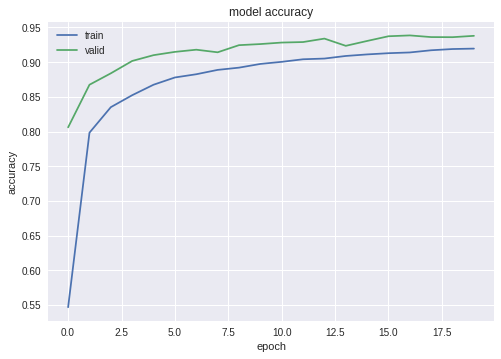

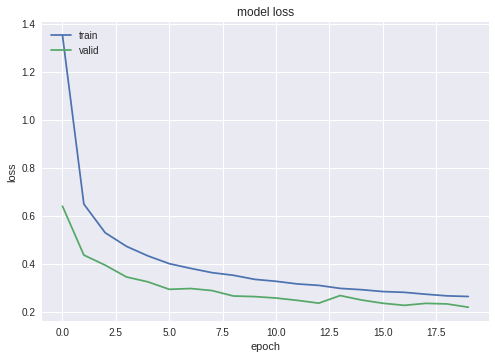

In [0]:
# с помощью Keras
from keras import backend as k
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt


# Часть 1 -подготовка
# сеть и ее обучение
NB_EPOCH = 20
BATCH_SIZE = 256
VERBOSE = 1
NB_CLASES = 10 #количество классов
# OPTIMIZER = SGD() # в качестве оптимизатора стохастический градиентный спуск
OPTIMIZER = Adam(lr=0.001)# в качестве оптимизатора стохастический градиентный спуск
# lr - скорость сходимости
#OPTIMIZER = RMSprop() # в качестве оптимизатора стохастический градиентный спуск
VALIDATION_SPLIT = 0.05 #сколько выделить примеров из обучающего набора на кросс-валидацию
IMG_ROWS, IMG_COLS = 32, 32 #размер входного изображения
INPUT_SHAPE = [3, IMG_ROWS, IMG_COLS]
k.set_image_dim_ordering("th")

# загружаем данные и перемешиваем и делим на обучение и тест
(X_train, Y_train), (X_test, Y_test) = (np.transpose(train_dataset, (0, 3, 2, 1)), train_labels), (np.transpose(test_dataset, (0, 3, 2, 1)), test_labels)
(X_valid, Y_valid) = (np.transpose(valid_dataset, (0, 3, 2, 1)), valid_labels)

# нам нужна форма 60К * [1*28*28], подаваемая на вход CNN
# X_train = X_train[:, np.newaxis, :, :]
# X_valid = X_valid[:, np.newaxis, :, :]

# для ядра tf меняем размерность изображений
# k.set_image_dim_ordering("tf")
# INPUT_SHAPE = [IMG_ROWS, IMG_COLS, 1]
# X_train = np.transpose(X_train, (0, 2, 3, 1))
# X_valid = np.transpose(X_valid, (0, 2, 3, 1))

print(X_train.shape, 'X_train.shape')
print(X_train.shape[0], 'train_samples')
print(X_valid.shape[0], 'valid_samples')

# унитарное кодирование меток - преобразование векторов классов в бинарные матрицы классов
# Y_train = np_utils.to_categorical(y_train, NB_CLASES)
# Y_valid = np_utils.to_categorical(y_valid, NB_CLASES)

# часть 2 - архитектура сети
class CNN:
    @staticmethod
    def build(input_shape, classes):
        model = Sequential()
        # CONV => RELU => POOL
        model = Sequential()
        # CONV => RELU => POOL
        model.add(Conv2D(16, kernel_size=3, padding='same', input_shape=input_shape, activation='relu'))
        model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=input_shape, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # CONV => RELU => POOL
        model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=input_shape, activation='relu'))
        model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=input_shape, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # слои Flatten => RELU
        # Flatten - слой уплотнения (то есть мы берем и вытягиваем получившиеся признаки в вектор
        # строку размрености (50*7*7, ))
        model.add(Flatten())
        model.add(Dropout(0.8))
        #  и плотный слой с 500 нейронами
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(0.3))
        # softmax -классификатор   
        model.add(Dense(classes, activation='softmax'))
        model.summary()
        return model

# инициализируем оптимизатор и модель
model = CNN.build(input_shape=INPUT_SHAPE, classes=NB_CLASES)
# орпеделеяем метод оптимизации и функцию потерь.
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
# обучение модели
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_data=(X_valid, Y_valid))
# вывод результатов работы
score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
print("TEST cost_function:", score[0])
print("TEST accuracy:", score[1])

# построить график изменения accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# построить график изменения функии потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [0]:
# сохранение архитектуры и весов

model_json = model.to_json()
json_file = open('CNN_SVHN_architecture.json', 'w')
json_file.write(model_json)
json_file.close()
# и веса, вычисленные в результате обучения сети
model.save_weights('CNN_SVHN_weights.h5', overwrite=True)

In [0]:
# загрузка модели

from keras.models import model_from_json
model_architecture = 'CNN_SVHN_architecture.json'
model_weights = 'CNN_SVHN_weights.h5'
model_new = model_from_json(open(model_architecture).read())
model_new.load_weights(model_weights)

#compile a model
model_new.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])


score = model_new.evaluate(X_test, Y_test, verbose=VERBOSE)
print("TEST cost_function:", score[0])
print("TEST accuracy:", score[1])



26032/26032 [==============================] - 4s 138us/step
TEST cost_function: 0.22371236367017194
TEST accuracy: 0.9419176398279041


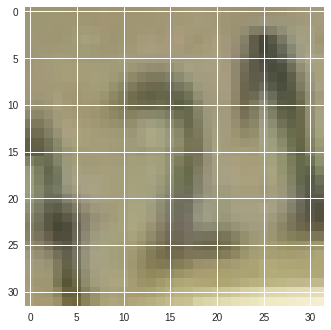

label 2
Предсказанная метка 2


In [0]:
# посмотреть правильно ли работает
X_example_all = train_data_set['X']
X_example_all = X_example_all.transpose((3, 0, 1, 2))

X_example = X_example_all[10000]

Y_example_all = train_data_set['y']
Y_example = Y_example_all[10000]

plt.imshow(X_example)
plt.show()
print('label {}'.format(Y_example[0]))


X_norm = X_example.transpose((2, 1, 0)).astype('float32')/255
X_reshape = X_norm[np.newaxis, :, :, :]

predictions = model.predict_classes(X_reshape)
print('Предсказанная метка {}'.format(predictions[0]))


In [0]:
# выгрузка из colaboratory google
from google.colab import files
files.download('CNN_SVHN_architecture.json')

In [0]:
files.download('CNN_SVHN_weights.h5')

In [0]:
# сохранение всей модели
from keras.models import load_model

model.save('CNN_SVHN_all_model.h5')

model1 = load_model('CNN_SVHN_all_model.h5')
model1.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_data=(X_valid, Y_valid))

In [0]:
files.download('CNN_SVHN_all_model.h5')

In [0]:
# обучение нейронных сетей за счет генерирования новых изображений.
# используется ранеее предобученная модель на это множестве
from keras.models import load_model
from keras import backend as k

model = load_model('CNN_SVHN_all_model.h5')

# print('Augmenting training set images...')
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Часть 1 -подготовка
# сеть и ее обучение
NB_EPOCH = 20
BATCH_SIZE = 256
VERBOSE = 1
NB_CLASES = 10 #количество классов
# OPTIMIZER = SGD() # в качестве оптимизатора стохастический градиентный спуск
OPTIMIZER = Adam(lr=0.001)# в качестве оптимизатора стохастический градиентный спуск
# lr - скорость сходимости
#OPTIMIZER = RMSprop() # в качестве оптимизатора стохастический градиентный спуск
VALIDATION_SPLIT = 0.05 #сколько выделить примеров из обучающего набора на кросс-валидацию
IMG_ROWS, IMG_COLS = 32, 32 #размер входного изображения
INPUT_SHAPE = [3, IMG_ROWS, IMG_COLS]
k.set_image_dim_ordering("th")



# загружаем данные
(X_train, Y_train), (X_test, Y_test) = (np.transpose(train_dataset, (0, 3, 2, 1)), train_labels), (np.transpose(test_dataset, (0, 3, 2, 1)), test_labels)
(X_valid, Y_valid) = (np.transpose(valid_dataset, (0, 3, 2, 1)), valid_labels)


# ЧТобы прямо на ходу аугментировать изображения и на них обучать сеть
# инициализация генератора
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE), steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                    epochs=NB_EPOCH, verbose=VERBOSE, validation_data=(X_valid, Y_valid))


Epoch 1/20
253/253 [==============================] - 39s 153ms/step - loss: 1.7848 - acc: 0.3881 - val_loss: 0.6306 - val_acc: 0.8630
Epoch 2/20
253/253 [==============================] - 37s 148ms/step - loss: 1.5125 - acc: 0.4764 - val_loss: 0.5370 - val_acc: 0.8727
Epoch 3/20
253/253 [==============================] - 37s 148ms/step - loss: 1.4011 - acc: 0.5216 - val_loss: 0.5770 - val_acc: 0.8510
Epoch 4/20
253/253 [==============================] - 38s 148ms/step - loss: 1.3287 - acc: 0.5449 - val_loss: 0.5902 - val_acc: 0.8340
Epoch 5/20
253/253 [==============================] - 38s 148ms/step - loss: 1.2638 - acc: 0.5729 - val_loss: 0.5675 - val_acc: 0.8392
Epoch 6/20
253/253 [==============================] - 37s 146ms/step - loss: 1.2286 - acc: 0.5862 - val_loss: 0.5594 - val_acc: 0.8386
Epoch 7/20
253/253 [==============================] - 38s 150ms/step - loss: 1.1863 - acc: 0.6012 - val_loss: 0.5934 - val_acc: 0.8278
Epoch 8/20
253/253 [==============================] - 3

In [0]:
# 2 этап дообучения на изначальны данных
from keras.models import load_model

model.save('CNN_SVHN_all_model.h5')

model1 = load_model('CNN_SVHN_all_model.h5')
model1.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=50,
                    verbose=VERBOSE, validation_data=(X_valid, Y_valid))

Train on 65000 samples, validate on 8257 samples
Epoch 1/50
65000/65000 [==============================] - 12s 182us/step - loss: 0.4094 - acc: 0.8737 - val_loss: 0.2690 - val_acc: 0.9266
Epoch 2/50
65000/65000 [==============================] - 11s 166us/step - loss: 0.3383 - acc: 0.8978 - val_loss: 0.2496 - val_acc: 0.9331
Epoch 3/50
65000/65000 [==============================] - 11s 167us/step - loss: 0.3156 - acc: 0.9051 - val_loss: 0.2636 - val_acc: 0.9288
Epoch 4/50
65000/65000 [==============================] - 11s 167us/step - loss: 0.2961 - acc: 0.9117 - val_loss: 0.2377 - val_acc: 0.9330
Epoch 5/50
65000/65000 [==============================] - 11s 166us/step - loss: 0.2856 - acc: 0.9151 - val_loss: 0.2326 - val_acc: 0.9376
Epoch 6/50
65000/65000 [==============================] - 11s 167us/step - loss: 0.2744 - acc: 0.9172 - val_loss: 0.2274 - val_acc: 0.9374
Epoch 7/50
65000/65000 [==============================] - 11s 165us/step - loss: 0.2668 - acc: 0.9201 - val_loss: 0.2

In [0]:
score = model1.evaluate(X_test, Y_test, verbose=VERBOSE)
print("TEST cost_function:", score[0])
print("TEST accuracy:", score[1])

26032/26032 [==============================] - 4s 148us/step
TEST cost_function: 0.18851145197761593
TEST accuracy: 0.9524815611555009


In [0]:
model1.save('CNN_SVHN_all_model_best.h5')

In [0]:
from google.colab import files
files.download('CNN_SVHN_all_model_best.h5')